# Libraries

In [9]:
import pickle
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from os.path import exists
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
import nltk
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize pandarallel
pandarallel.initialize()

# Load nltk stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))



INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yasasvimalladi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yasasvimalladi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

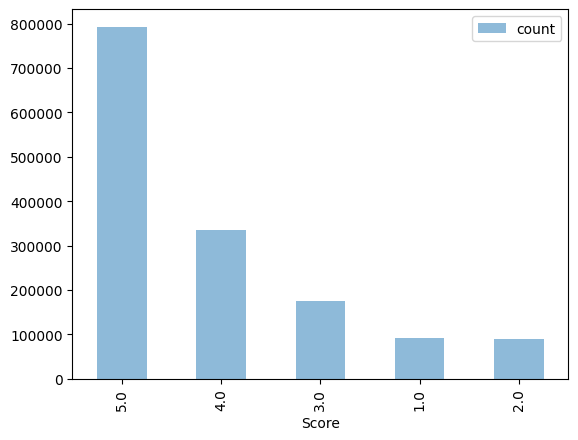


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [11]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [16]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Convert time to datetime
    df['Date'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    # Sentiment analysis on review text and summary
    df['Text_Sentiment'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Summary_Sentiment'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    return df

# Check if pre-processed data exists
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id for submission set
    X_submission = pd.merge(train, testingSet, on='Id')
    X_submission = X_submission[X_submission['Score_y'].isna()]  # Ensure only submission entries are considered
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # Training set where the score is not null
    X_train = train[train['Score'].notnull()]
    

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)



# Sample + Split into training and testing set

In [18]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)


# Feature Selection

In [19]:
# Include all available features
features = X_train.columns.drop(['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Time', 'Date'])

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn = KNeighborsClassifier()

# Define a grid of parameters
param_grid = {
    'n_neighbors': [3, 25, 50, 100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Setup the grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_select, Y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score: {:.2%}".format(grid_search.best_score_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 100, 'weights': 'uniform'}
Best cross-validated score: 55.49%


In [20]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=60)
model.fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)
Y_submission_predictions = model.predict(X_submission_select)


# Model Evaluation

Accuracy on testing set =  0.5510858090785703


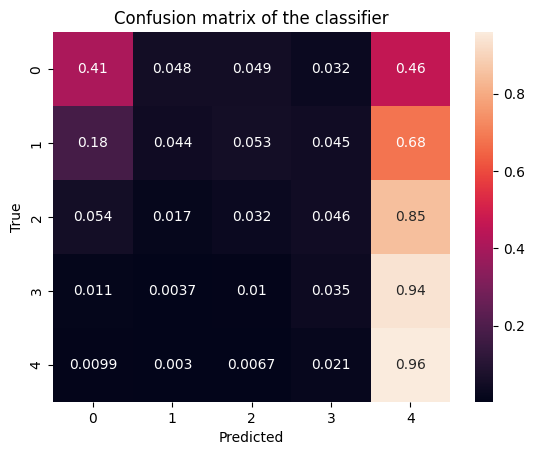

In [21]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [137]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)